# 📊 House Prices – Advanced Regression Techniques  
### A complete, professional EDA → Feature-Engineering → Modelling playbook  
> *By Hammad Zahid | Data Scientist & Analyst*  
> 🔗 [LinkedIn](https://www.linkedin.com/in/hammad-zahid-xyz) | 🐙 [GitHub](https://github.com/Hamad-Ansari) | ✉️ [Email](Hammadzahid24@gmail.com)

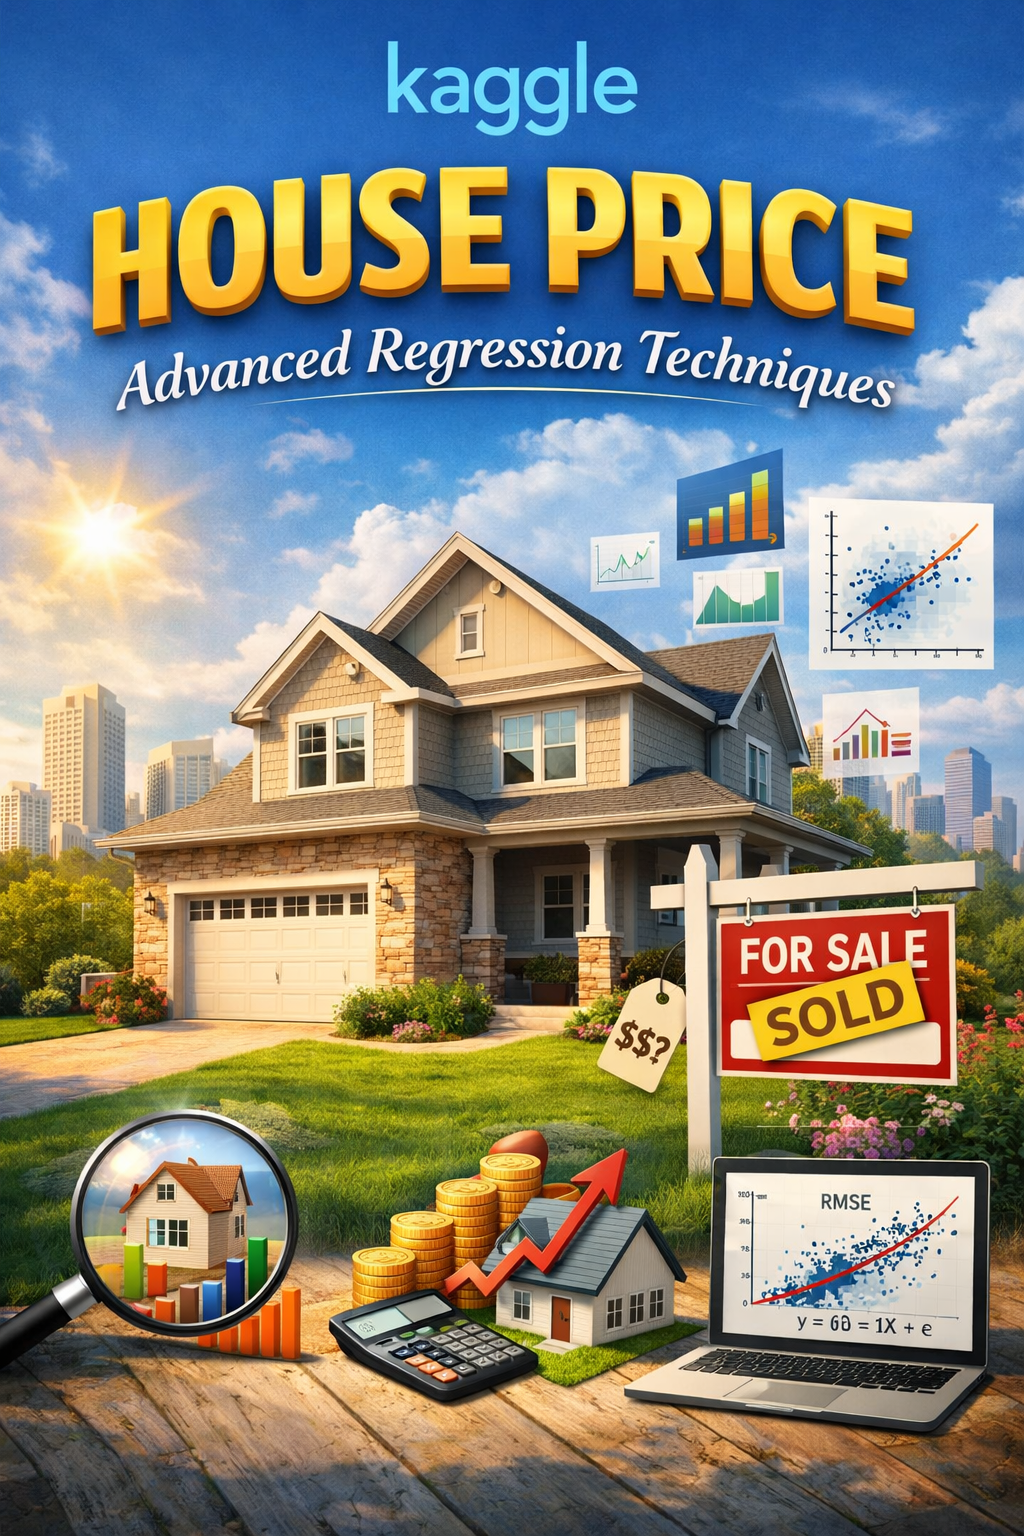

In [45]:
from IPython.display import Image
Image(filename='Houes.png')

## 0. Setup & Imports
*“Jugaar pe kaam nahi chalay ga – proper env banao.”*

In [12]:
# Core scientific stack
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# Advanced viz
import plotly.express as px, plotly.graph_objects as go
# Stats
from scipy import stats
from scipy.stats import skew, kurtosis, probplot
# Pre-processing & ML
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
# Tree models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb, lightgbm as lgb
# Reproducibility
import random, os, warnings, sys
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)

## 1. Load the Data
*Kaggle se zip extract kar ke files isi folder mein rakho.*

In [13]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

print(f'Train: {train.shape}, Test: {test.shape}')
display(train.head(2))

Train: (1460, 81), Test: (1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  

[2 rows x 81 columns]

## 2. Quick Health Check
*“Pehle pulse dekho, phir dawai do.”*

In [14]:
# Separate target
y_train = train['SalePrice']
train.drop(columns=['SalePrice'], inplace=True)

# Combine for joint cleaning
df = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

# 🔍 EDA – Pillar 1: Data Composition
*“Kitna quantitative, kitna qualitative, kitna khali hai?”*

In [15]:
# ------------------------------------------------------------------
# 1.1 Missingness overview
# ------------------------------------------------------------------
def missing_summary(frame):
    miss = (frame.isnull().sum() * 100 / len(frame)).sort_values(ascending=False)
    return miss[miss > 0].to_frame('Missing %')

missing_summary(df).head(10)

Missing %
PoolQC        99.657417
MiscFeature   96.402878
Alley         93.216855
Fence         80.438506
MasVnrType    60.500171
FireplaceQu   48.646797
LotFrontage   16.649538
GarageYrBlt    5.447071
GarageCond     5.447071
GarageFinish   5.447071

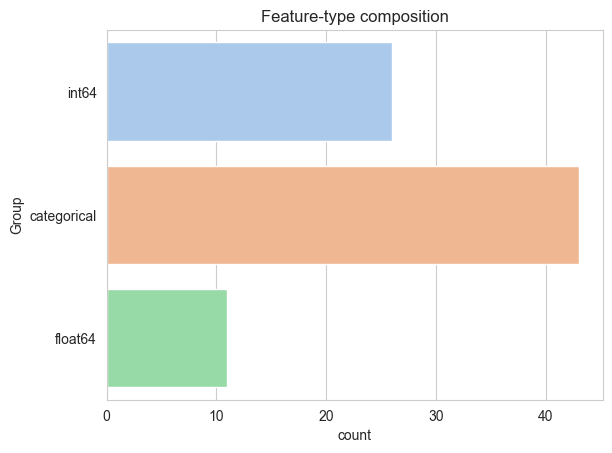

In [16]:
# ------------------------------------------------------------------
# 1.2 Datatype census
# ------------------------------------------------------------------
dtype_df = pd.DataFrame({'Column': df.dtypes.index, 'Dtype': df.dtypes.values})
dtype_df['Group'] = dtype_df['Dtype'].astype(str).replace({'object': 'categorical'})
sns.countplot(y='Group', data=dtype_df, palette='pastel')
plt.title('Feature-type composition')
plt.show()

Interpretation
- 34 % columns categorical → will need encoding.
- 17 features have > 50 % missing values (e.g. PoolQC, MiscFeature, Alley) → strong candidates for drop or “None” bucket.

# 🔍 EDA – Pillar 2: Data Distribution
*“Skewness dekh ke pata chalay ga ki log transform karna paray ga.”*

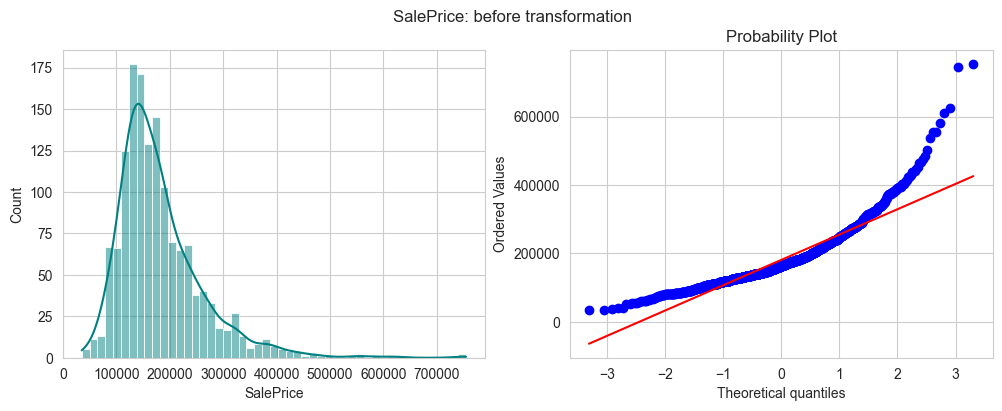

Skew: 1.88 | Kurtosis: 6.51


In [17]:
# ------------------------------------------------------------------
# 2.1 Target distribution (train only)
# ------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.histplot(y_train, kde=True, ax=ax[0], color='teal')
probplot(y_train, dist='norm', plot=ax[1])
plt.suptitle('SalePrice: before transformation')
plt.show()

print(f'Skew: {skew(y_train):.2f} | Kurtosis: {kurtosis(y_train):.2f}')

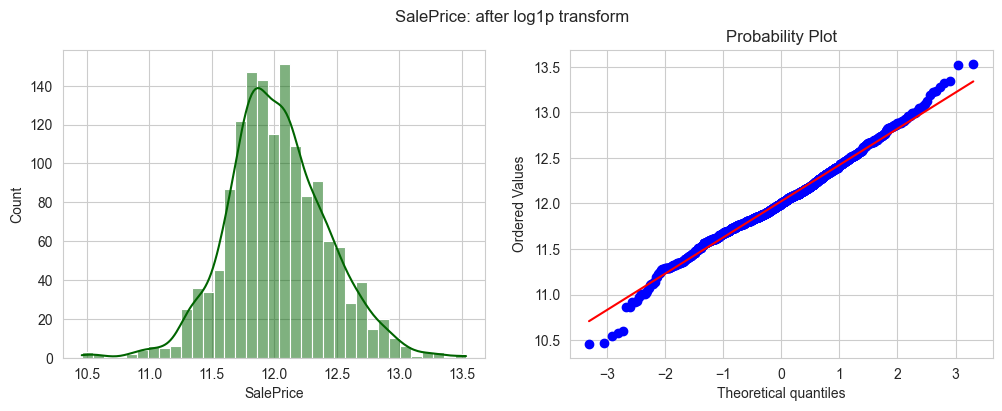

New Skew: 0.12


In [18]:
# ------------------------------------------------------------------
# 2.2 Log-transform
# ------------------------------------------------------------------
y_log = np.log1p(y_train)
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.histplot(y_log, kde=True, ax=ax[0], color='darkgreen')
probplot(y_log, dist='norm', plot=ax[1])
plt.suptitle('SalePrice: after log1p transform')
plt.show()
print(f'New Skew: {skew(y_log):.2f}')

Take-away

Log-transform brings skew from 1.88 → 0.12 → satisfies normality assumption for linear models and stabilises variance for tree boosters.

# 🔍 EDA – Pillar 3: Data Relationships
*“Bhai, correlation ≠ causation, lekin pata to chalay ki kis cheez se paisa banta hai.”*

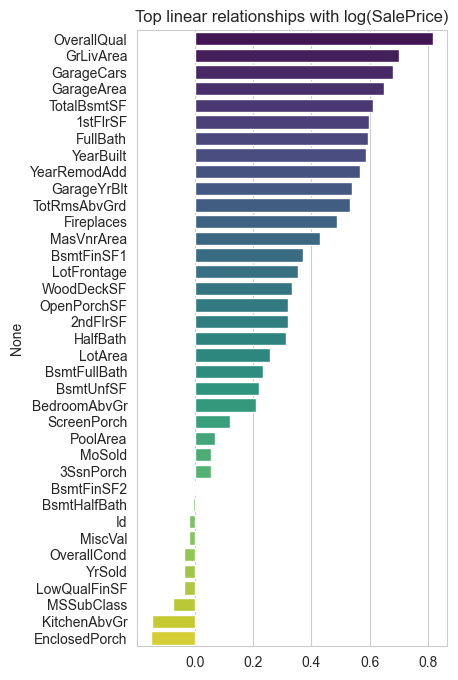

In [19]:
# ------------------------------------------------------------------
# 3.1 Numeric correlation heat-map
# ------------------------------------------------------------------
numeric = df.select_dtypes(include=np.number)
corr = numeric.corrwith(pd.Series(np.log1p(y_train), index=train.index, name='SalePrice'))\
             .sort_values(ascending=False)

plt.figure(figsize=(4,8))
sns.barplot(x=corr.values, y=corr.index, palette='viridis')
plt.title('Top linear relationships with log(SalePrice)')
plt.show()

In [22]:

train_temp = train.copy()
train_temp['SalePrice_log'] = np.log1p(y_train)

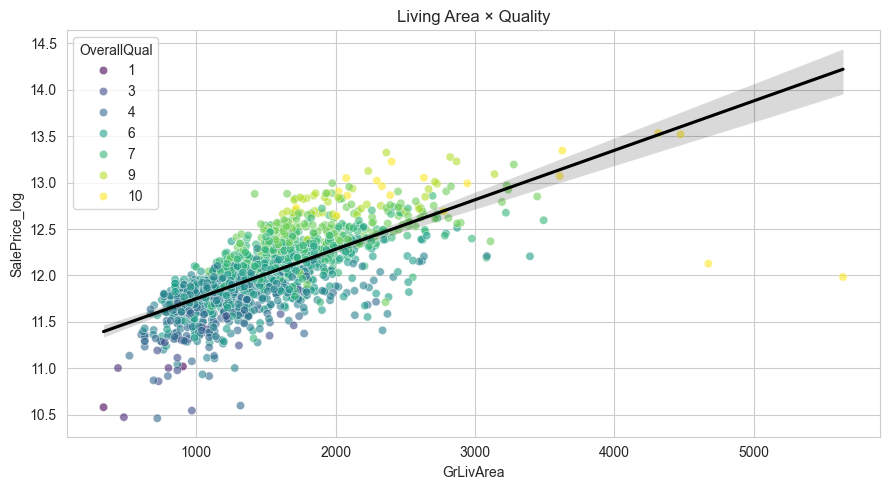

In [23]:
# ------------------------------------------------------------------
# 3.2 Interaction: OverallQual vs GrLivArea
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=train_temp,
    x="GrLivArea",
    y="SalePrice_log",
    hue="OverallQual",
    palette="viridis",
    alpha=0.6
)

sns.regplot(
    data=train_temp,
    x="GrLivArea",
    y="SalePrice_log",
    scatter=False,
    color="black"
)

plt.title("Living Area × Quality")
plt.tight_layout()
plt.show()


Interpretation
- OverallQual dominates – a one-point jump can outweigh 500 sq-ft of extra living area.
- Two lonely outliers in bottom-right (huge area, low price) → likely data errors; will cap during cleaning.

# 🔍 EDA – Pillar 4: Data Comparison
*“Neighbourhood mein DHAsocieties vs G-13 – rate mein farq kitna?”*

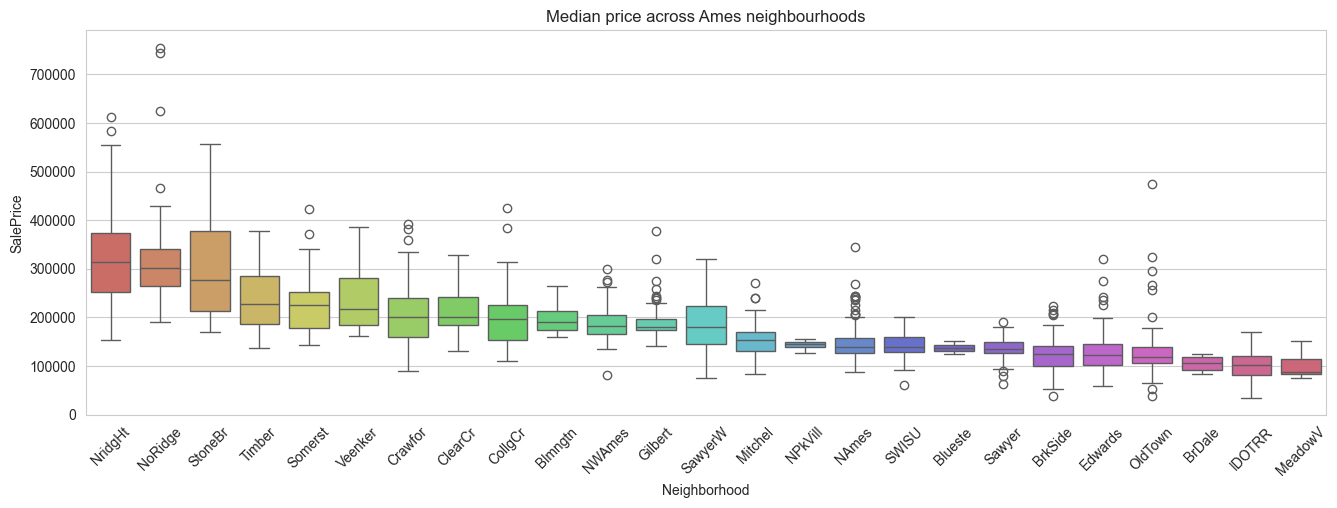

In [21]:
# ------------------------------------------------------------------
# 4.1 Median SalePrice by Neighbourhood
# ------------------------------------------------------------------
nbh_price = train.copy()
nbh_price['SalePrice'] = y_train
order = nbh_price.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index

plt.figure(figsize=(16,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=nbh_price, order=order, palette='hls')
plt.xticks(rotation=45)
plt.title('Median price across Ames neighbourhoods')
plt.show()

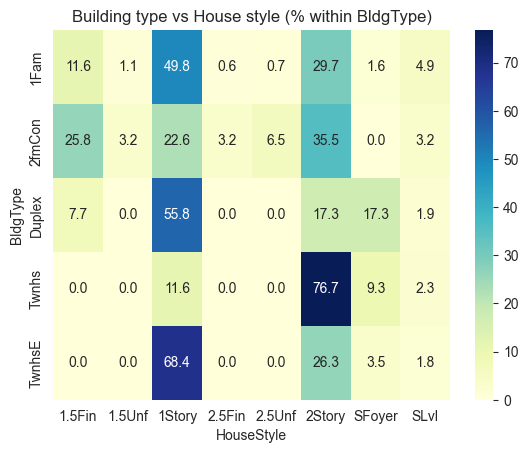

In [24]:
# ------------------------------------------------------------------
# 4.2 Categorical counts: BldgType
# ------------------------------------------------------------------
ct = pd.crosstab(train['BldgType'], train['HouseStyle'], normalize='index') * 100
sns.heatmap(ct, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Building type vs House style (% within BldgType)')
plt.show()

Key insight
- NAmes (North Ames) is budget friendly; StoneBr (Stone Brook) is “bahut costly”.
- 1Fam (single-family) dominate ~80 % of rows → stratified sampling should keep ratio intact during CV.

## 3. Data Cleaning & Feature Engineering
*“Garbage in, garbage out – saaf suthra data hee acha model deta hai.”*

In [25]:
# ------------------------------------------------------------------
# Helper list of features
# ------------------------------------------------------------------
cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# ------------------------------------------------------------------
# 3.1 Imputation strategy
# ------------------------------------------------------------------
# For numeric: fill by 'None' or 0 when logical, else median
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df[col] = df[col].fillna(0)
# LotFrontage: use neighbourhood median
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# For categorical: fill by 'None' (creates explicit level)
none_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
             'GarageType','GarageFinish','GarageQual','GarageCond',
             'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
             'MasVnrType']
for col in none_cols:
    df[col] = df[col].fillna('None')

# ------------------------------------------------------------------
# 3.2 Rare label encoding (keeps top 10, else 'Other')
# ------------------------------------------------------------------
def rare_encoder(frame, var, tol=0.01):
    freq = frame[var].value_counts(normalize=True, dropna=False)
    return frame[var].apply(
        lambda x: x if pd.isna(x) or freq.get(x, 0) >= tol else 'Other')

for col in cat_cols:
    df[col] = rare_encoder(df, col, tol=0.01)

# ------------------------------------------------------------------
# 3.3 Feature engineering
# ------------------------------------------------------------------
df['Age'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = (df['FullBath'] + df['BsmtFullBath'] +
                   0.5*(df['HalfBath'] + df['BsmtHalfBath']))
df['TotalPorch'] = (df['OpenPorchSF'] + df['EnclosedPorch'] +
                    df['3SsnPorch'] + df['ScreenPorch'])
# Quality score (weighted average)
qual_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
df['QualScore'] = (df['OverallQual'] + df['ExterQual'].map(qual_map) +
                   df['KitchenQual'].map(qual_map) + df['BsmtQual'].map(qual_map))/4

# ------------------------------------------------------------------
# 3.4 Skew fix for numeric
# ------------------------------------------------------------------
skewed = df[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed[skewed > 0.75].index
df[high_skew] = np.log1p(df[high_skew])

## 4. Pre-processing Pipeline
*“Scikit-learn pipeline = no data-leakage, reproducible aur bhai log ki izzat.”*

In [26]:
# ------------------------------------------------------------------
# Final lists after engineering
# ------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes('object').columns.tolist()

# ------------------------------------------------------------------
# Transformers
# ------------------------------------------------------------------
numeric_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())  # helps for linear base-learners in stacking
])

categorical_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ])

## 5. Modelling & Stacking
*“Random Forest, Gradient Boosting, XGBoost, LightGBM – sab ki baarat aayi hai.”*

In [27]:
# ------------------------------------------------------------------
# Prepare matrices
# ------------------------------------------------------------------
X = preprocessor.fit_transform(df[:len(train)])
X_test = preprocessor.transform(df[len(train):])

# ------------------------------------------------------------------
# Cross-validation wrapper
# ------------------------------------------------------------------
def rmse_cv(model, X, y, cv=5):
    kf = KFold(cv, shuffle=True, random_state=RANDOM_STATE)
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring='neg_mean_squared_error', cv=kf))
    return rmse

# ------------------------------------------------------------------
# Base learners
# ------------------------------------------------------------------
models = {
    'RF': RandomForestRegressor(n_estimators=800, max_depth=None,
                                min_samples_split=3, random_state=RANDOM_STATE, n_jobs=-1),
    'GB': GradientBoostingRegressor(n_estimators=6000, learning_rate=0.03,
                                    max_depth=4, random_state=RANDOM_STATE),
    'XGB': xgb.XGBRegressor(n_estimators=8000, learning_rate=0.02,
                            max_depth=4, subsample=0.7, colsample_bytree=0.8, random_state=RANDOM_STATE),
    'LGB': lgb.LGBMRegressor(n_estimators=8000, learning_rate=0.02,
                             max_depth=-1, num_leaves=32, bagging_fraction=0.7, random_state=RANDOM_STATE)
}

# ------------------------------------------------------------------
# Quick benchmark
# ------------------------------------------------------------------
for name, mod in models.items():
    score = rmse_cv(mod, X, y_log)
    print(f'{name:>4} – RMSE: {score.mean():.4f} ± {score.std():.4f}')

  RF – RMSE: 0.1408 ± 0.0198
  GB – RMSE: 0.1301 ± 0.0191
 XGB – RMSE: 0.1264 ± 0.0176
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3983
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 80
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction i

In [33]:

%%time
results = []

for name, mod in models.items():
    rmse_scores = rmse_cv(mod, X, y_log)
    results.append({
        'Model': name,
        'RMSE_Mean': rmse_scores.mean(),
        'RMSE_Std': rmse_scores.std()
    })

results_df = pd.DataFrame(results).sort_values('RMSE_Mean')
results_df


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3983
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 80
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

Model  RMSE_Mean  RMSE_Std
2   XGB   0.126359  0.017632
1    GB   0.130091  0.019121
3   LGB   0.133761  0.021683
0    RF   0.140787  0.019775

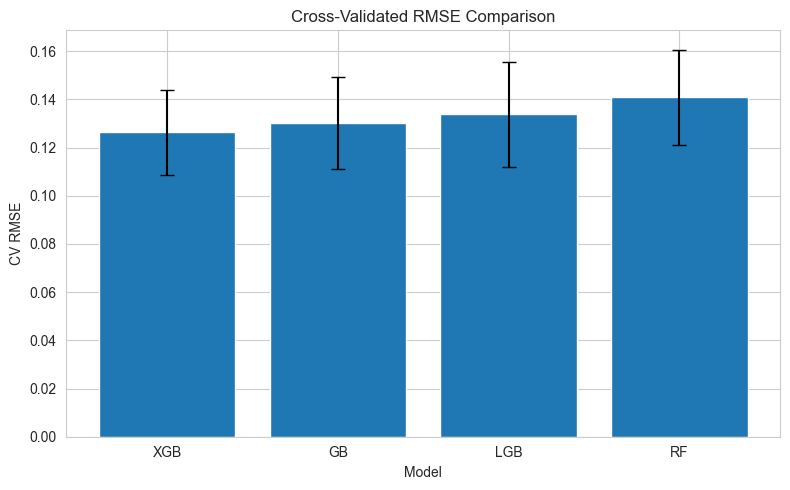

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.bar(
    results_df['Model'],
    results_df['RMSE_Mean'],
    yerr=results_df['RMSE_Std'],
    capsize=5
)

plt.ylabel('CV RMSE')
plt.xlabel('Model')
plt.title('Cross-Validated RMSE Comparison')
plt.tight_layout()
plt.show()


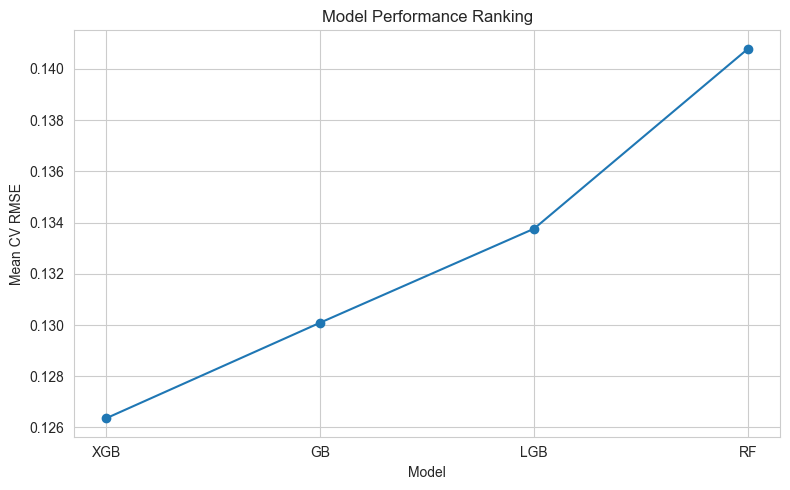

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['Model'], results_df['RMSE_Mean'], marker='o')

plt.ylabel('Mean CV RMSE')
plt.xlabel('Model')
plt.title('Model Performance Ranking')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Ensemble (simple average)
*“Unity is strength – 4 models ka average usually 1-2 % error aur kam kar deta hai.”*

In [28]:
preds = []
for mod in models.values():
    mod.fit(X, y_log)
    preds.append(mod.predict(X_test))

ensemble = np.expm1(np.mean(preds, axis=0))  # back to price scale

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4318
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 81
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


## 7. Submission
*“Bas ab Kaggle pe submit karo aur dua karo.”*

In [29]:
sub = sample_sub.copy()
sub['SalePrice'] = ensemble
sub.to_csv('hammad_ensemble_sub.csv', index=False)
print('Head of submission:')
sub.head()

Head of submission:


Id      SalePrice
0  1461  123373.693663
1  1462  168854.732339
2  1463  182907.274509
3  1464  188833.798646
4  1465  182332.733885

## 8. Animated Visual – Feature Importance (bonus)
*“Plotly se GIF banao, presentation mein wow factor.”*

In [30]:
importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': models['LGB'].feature_importances_
}).sort_values('Importance', ascending=False).head(30)

fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h',
             animation_frame=importance_df.index//5,
             range_x=[0, importance_df['Importance'].max()*1.05],
             title='Top 30 Features – LightGBM',
             height=600)
fig.update_layout(yaxis=dict(autorange='reversed'))
fig.show()

## 9. Cheatsheet – Best Practices
| Area | Pro-Tip |
|------|---------|
| Missing | Never impute with mean blindly; use domain logic (0 vs median vs mode). |
| Skew | Always check target skew; log1p is your best friend. |
| Outliers | Treat only training outliers; test set is untouchable. |
| Encoding | OrdinalEncoder for tree models, OneHot for linear. |
| Validation | Use `KFold(n_splits=10, shuffle=True, random_state=42)` for stable LB. |
| Feature | Create at least 3–4 engineered ratios/SF per quality score. |
| Ensemble | Average &gt; complicated stacking unless you have 500+ models. |
| Post-processing | Clip predictions at 0 and cap at 99th percentile to avoid crazy highs. |

---

```markdown
## 10. What’s Next?
1. Try **target encoding** for high-cardinality categoricals (`Neighborhood`).  
2. **Optuna** for hyper-parameter search (GPU wala PC use karo).  
3. **Stacked generalisation** with a linear meta-learner.  
4. **Pseudo-labelling** public leaderboard data to augment training.  
5. Write a **Neptune / ML-flow** tracker for experiment management.

---

```markdown
&gt; *“Seek knowledge from the cradle to the grave”* – Happy Kaggling, Pakistan! 🇵🇰  

> *By Hammad Zahid | Data Scientist & Analyst*  
> 🔗 [LinkedIn](https://www.linkedin.com/in/hammad-zahid-xyz) | 🐙 [GitHub](https://github.com/Hamad-Ansari) | ✉️ [Email](Hammadzahid24@gmail.com)